## Colab 기본 환경 설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output 

!pip install transformers==4.8.2
!pip install sentencepiece==0.1.96
!pip install tensorflow_addons

clear_output()

import sklearn
from sklearn import model_selection
from sklearn.metrics import accuracy_score 

import transformers
from transformers import TFBertModel # BertTokenizer 제외

import tensorflow as tf
import tensorflow_addons as tfa # for using Rectified-Adam optimizer (instead of Adam optimizer) 
from tensorflow.keras import layers, initializers, losses, optimizers, metrics, callbacks

print(sklearn.__version__) # 1.0.2
print(tf.__version__) # 2.8.0
print(transformers.__version__) # 4.8.2
print(tfa.__version__) # 0.16.1

import sentencepiece

import pandas as pd
import numpy as np

import os
import re
import pickle 
import dill # for saving a function as a file(.pkl)
import logging # for changing the tf's logging level
import urllib.request
from tqdm import tqdm

import sentencepiece as spm

1.0.2
2.8.2
4.8.2
0.18.0


In [ ]:
# Random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

# Transformers logging level 변경 (WARNING -> ERROR) @ https://huggingface.co/transformers/main_classes/logging.html
transformers.logging.set_verbosity(transformers.logging.ERROR)

# Tensorflow logging level 변경 
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
# from google.colab import files
# file_uploaded = files.upload()

## 한국어 말뭉치 데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/딥러닝 미니프로젝트/chat_6label.csv', encoding='utf-8', index_col=0)
df

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
45475,뭐? 다시 한 번 말해봐.,분노
45476,어? 정말요?,놀람
45477,"혹시, 다들 은행 계좌없는 거예요?",놀람
45478,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,분노


## 데이터 전처리

In [ ]:
df.groupby('Emotion').count()

,Sentence
Emotion,
공포,5468
놀람,10764
분노,9293
슬픔,7239
행복,7067
혐오,5649


- 공포:0, 놀람:1, 분노:2, 혐오:3, 슬픔:4, 행복:5

In [ ]:
df['Emotion'] = df['Emotion'].str.replace('공포', '0')
df['Emotion'] = df['Emotion'].str.replace('놀람', '1')
df['Emotion'] = df['Emotion'].str.replace('분노', '2')
df['Emotion'] = df['Emotion'].str.replace('혐오', '3')
df['Emotion'] = df['Emotion'].str.replace('슬픔', '4')
df['Emotion'] = df['Emotion'].str.replace('행복', '5')

In [ ]:
df

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
45475,뭐? 다시 한 번 말해봐.,2
45476,어? 정말요?,1
45477,"혹시, 다들 은행 계좌없는 거예요?",1
45478,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,2


In [ ]:
df = df.rename(columns={'Emotion':'Label'})

In [ ]:
df

,Sentence,Label
0,언니 동생으로 부르는게 맞는 일인가요..??,0
1,그냥 내 느낌일뿐겠지?,0
2,아직너무초기라서 그런거죠?,0
3,유치원버스 사고 낫다던데,0
4,근데 원래이런거맞나요,0
...,...,...
45475,뭐? 다시 한 번 말해봐.,2
45476,어? 정말요?,1
45477,"혹시, 다들 은행 계좌없는 거예요?",1
45478,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,2


#### train, test 데이터 분리

- 여기서 random_state값을 42 -> 0 으로 변경 후 과대적합 문제가 조금 나아짐
- 1,2,3... 조금씩 숫자를 올려가면 최적의 조합을 찾아야함 

In [ ]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['Sentence'], df['Label'], 
                                                                    test_size=0.3, 
                                                                    random_state=2) # 0으로 지정해서 매번 순서가 다르게 만듦(값을 조정하면서 과대적합 해결해보기)

In [ ]:
# 전체데이터를 훈련데이터로 
# train_x, train_y = df['Sentence'], df['Label']

## github에서 KoBERT 파일을 로드 및 KoBERT모델 불러오기

In [ ]:
#KoBERT 불러오기
!git clone https://github.com/monologg/KoBERT-Transformers.git
!mv KoBERT-Transformers/kobert_transformers/tokenization_kobert.py /content
clear_output() # clear the output

#토크나이저 생성
# from tokenization_kobert import KoBertTokenizer 

# tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [ ]:
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

In [ ]:
df['Sentence'].str.len().sort_values(ascending=False)[:5]

13808    299
27433    298
33339    295
31758    261
43296    209
Name: Sentence, dtype: int64

In [ ]:
train_x

1334                          진짜 한두시간 정도밖에 안지났다고 생각했는데..ㅠㅠ
42291                             아니요...그냥 비가 좀 맞고 싶었어요...
38746            내가 이럴줄 알았어. 어떻게 인질을 골라두 저런 걸 고르냐? 네가 해봐! 
33468    통계적으로 비인기팀 맞으나 지방팀은 도단위로 팬을 나눠갖고 서울팀은 천만인데 달랑 ...
20878                                          어떻게생각하시나요 ㅠ
                               ...                        
44566    지난번에 만났을 때 했던 이야기. 바비큐는 아니지만 카레 만들었고, 수영장은 아니지...
30280                             좌좀 좌좀 거리는 무좀 한마리가 기어들어왔네
6637                                            헐..지딸인가..?
35343                              하지만 아무것도 현실같이 느껴지지 않아요.
23720                                       에바그린은 신의 뜻입니다.
Name: Sentence, Length: 31836, dtype: object

In [ ]:
# train_sentence = train_x.iloc[idx]
# train_label = train_y.iloc[idx]

# 예시
print(train_x.iloc[0], train_y.iloc[0])

진짜 한두시간 정도밖에 안지났다고 생각했는데..ㅠㅠ 0


#### train 데이터 정제(train_inputs, train_labels)

In [ ]:
SEQ_LEN = 300

token_ids = []
token_segments = []
token_masks = []

# token_ids : 문장을 토크나이즈해서 인덱스 값으로 변환
# token_segments : 0과 1로 문장의 토큰 값을 분리(첫번째 문장=0, 두번째 문장=1) -> 문장 구분용
# token_masks : 패딩된 부분은 학습에 영향을 받지 않게 처리해주는 입력 값(문장=1, 패딩=0)    

train_labels = []

for idx in tqdm(range(len(train_x))):

  # 'Sentence'컬럼에서 0번째 행~ 꺼내오기
  train_sentence = train_x.iloc[idx] 

  # 모든 특수문자 제거
  cleaned_sentence = re.sub('[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', '', train_sentence)
  
  # 토큰화 + 토큰별 시퀀스번호 부여 + 패딩
  encoded_dict = tokenizer.encode_plus(text = cleaned_sentence,
                                       padding='max_length',
                                       truncation=True, #True 인 경우 모델이 입력으로 받을 수 있는 최대의 길이에 맞춰서 truncation
                                       # truncation : 음절이나 어절 기준이 아닌 토크나이징했을 때의 토큰 기준으로 자르는 것
                                       max_length=SEQ_LEN
                                       )
  
  #'input_ids', 'token_type_ids', 'attention_mask'
  token_ids.append(encoded_dict['input_ids'])
  token_masks.append(encoded_dict['attention_mask'])
  token_segments.append(encoded_dict['token_type_ids'])

  train_labels.append(train_y.iloc[idx])


train_inputs = (np.array(token_ids), np.array(token_masks), np.array(token_segments))
train_labels = np.array(train_labels)

100%|██████████| 31836/31836 [00:10<00:00, 3128.18it/s]


In [ ]:
print(train_labels.shape, train_inputs[0].shape, train_inputs[1].shape, train_inputs[2].shape)

(31836,) (31836, 300) (31836, 300) (31836, 300)


In [ ]:
#train_inputs[0][0], 
#train_inputs[1][0]
#train_inputs[2][0]
tokenizer.decode(train_inputs[0][0])

'[CLS] 진짜 한두시간 정도밖에 안지났다고 생각했는데ㅠㅠ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

### 모델 생성

In [ ]:
def emo_model(max_length=300):

    bert_base_model = TFBertModel.from_pretrained('klue/bert-base', from_pt=True) 

    input_token_ids   = layers.Input((max_length,), dtype=tf.int32, name='input_token_ids')   
    input_masks       = layers.Input((max_length,), dtype=tf.int32, name='input_masks')       
    input_segments    = layers.Input((max_length,), dtype=tf.int32, name='input_segments')      

    bert_outputs = bert_base_model([input_token_ids, input_masks, input_segments]) 
    

    bert_outputs = bert_outputs[1] 
    bert_outputs = layers.Dropout(0.5)(bert_outputs) # 과대적합 해결을 위해 0.2-> 0.5로 변경
    final_output = layers.Dense(units=6, activation='softmax', kernel_initializer=initializers.TruncatedNormal(stddev=0.02), name='classifier')(bert_outputs)
    # unit=6 <-6가지 감정

    model = tf.keras.Model(inputs=[input_token_ids, input_masks, input_segments], outputs=final_output)

    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.0001, weight_decay=0.0025, warmup_proportion=0.05)
    loss = losses.SparseCategoricalCrossentropy()

    model.compile(optimizer=optimizer,
                  loss=loss, 
                  metrics=[metrics.SparseCategoricalAccuracy()])
    
    return model

In [ ]:
print(type(token_ids[0][0]))
print(type(token_masks[0][0]))
print(type(token_segments[0][0]))
# print(token_segments[0][0])

<class 'int'>
<class 'int'>
<class 'int'>


- 학습 오류 해결책 > train_labels을 int로 변경해줘야 함

In [ ]:
train_labels = train_labels.astype(np.int32)

In [ ]:
train_labels.dtype

dtype('int32')

In [ ]:
# model.summary()

In [ ]:
# TPU setting

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("\nAll devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope(): 
  model = emo_model(max_length=300)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0



All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
checkpoint_path = '/content/drive/MyDrive/딥러닝 미니프로젝트/save_model'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path + 'best_bert_weights_v3.h5', 
                                                monitor='val_sparse_categorical_accuracy',
                                                save_best_only=True, 
                                                save_weights_only = True, 
                                                verbose=1) 
                                                
earlystopping = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                             min_delta=0.0001, 
                                             patience=5)

In [ ]:
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

### 학습

In [ ]:
# with tf.device('/device:GPU:0'):
history = model.fit(train_inputs, train_labels, validation_split=0.25,
                    epochs=10, batch_size=64,
                    verbose=1,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/10


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]


374/374 [==============================] - ETA: 0s - loss: 1.2359 - sparse_categorical_accuracy: 0.5118

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]



Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.61050, saving model to /content/drive/MyDrive/딥러닝 미니프로젝트/save_modelbest_bert_weights_v3.h5
374/374 [==============================] - 265s 410ms/step - loss: 1.2359 - sparse_categorical_accuracy: 0.5118 - val_loss: 1.0134 - val_sparse_categorical_accuracy: 0.6105
Epoch 2/10
374/374 [==============================] - ETA: 0s - loss: 0.9441 - sparse_categorical_accuracy: 0.6403
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.61050
374/374 [==============================] - 77s 205ms/step - loss: 0.9441 - sparse_categorical_accuracy: 0.6403 - val_loss: 1.0204 - val_sparse_categorical_accuracy: 0.6046
Epoch 3/10
374/374 [==============================] - ETA: 0s - loss: 0.7264 - sparse_categorical_accuracy: 0.7272
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.61050
374/374 [==============================] - 75s 201ms/step - loss: 0.7264 - sparse_categorical_accuracy: 0.7272 - val

In [ ]:
history.history

{'loss': [1.2358766794204712,
  0.9441168308258057,
  0.726387083530426,
  0.5144383311271667,
  0.352072149515152,
  0.24875573813915253],
 'sparse_categorical_accuracy': [0.5118314623832703,
  0.6402814388275146,
  0.7272270321846008,
  0.8106964826583862,
  0.875863790512085,
  0.9142689108848572],
 'val_loss': [1.0134490728378296,
  1.0203664302825928,
  1.0883697271347046,
  1.232572317123413,
  1.4460227489471436,
  1.5599586963653564],
 'val_sparse_categorical_accuracy': [0.6105038523674011,
  0.6045985817909241,
  0.6032165288925171,
  0.6013318300247192,
  0.5902751684188843,
  0.5934162735939026]}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 

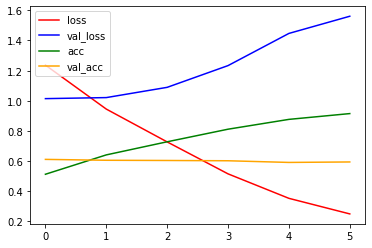

In [ ]:
# 시각화(loss, val_loss, acc, val_acc)
history.history.keys()

loss = history.history['loss']
x = np.arange(len(loss))

plt.plot(x, loss, c='red', label='loss')
plt.plot(x, history.history['val_loss'], c='blue', label='val_loss')
plt.plot(x, history.history['sparse_categorical_accuracy'], c='green', label='acc')
plt.plot(x, history.history['val_sparse_categorical_accuracy'], c='orange', label='val_acc')

plt.legend()

plt.show()

### 모델 저장

In [ ]:
save_path = '/content/drive/MyDrive/딥러닝 미니프로젝트/save_model'

with open(save_path + 'model_BERTfunction_v4.pkl', 'wb') as f:
    pickle.dump(dill.dumps(emo_model), f) 

with open(save_path + 'tokenizer-bert_v4.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### 모델 불러오기

In [ ]:
save_path = '/content/drive/MyDrive/딥러닝 미니프로젝트/'

with open(save_path + 'model_BERTfunction_fin.pkl', 'rb') as f:
    emo_model = dill.loads(pickle.load(f)) # use dill to pickle a python function

# 2) Load the Bert-tokenizer 
with open(save_path + 'tokenizer-bert_fin.pkl', 'rb') as f:
    tokenizer = pickle.load(f) 


# 3) Create the model & load the Model-weights (from checkpoint file)
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver) # Obsolete : tf.distribute.experimental.TPUStrategy()

with strategy.scope(): 
    model = emo_model(max_length=300) 

checkpoint_path = '/content/drive/MyDrive/딥러닝 미니프로젝트/'
model.load_weights(filepath=checkpoint_path + 'best_bert_weights_v3.h5')

#### 정확도 확인(test_x, test_y 정제)

In [ ]:
SEQ_LEN = 300

token_ids =[]
token_masks =[]
token_segments =[]

test_labels = []


for idx in tqdm(range(len(test_x))):

    test_sentence = test_x.iloc[idx]
    
    # 특수문자 제거
    cleaned_sentence = re.sub("[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]", "", test_sentence) 
    
    encoded_dict = tokenizer.encode_plus(text=cleaned_sentence,
                                         padding='max_length', 
                                         truncation=True,
                                         max_length=SEQ_LEN)
    
    token_ids.append(encoded_dict['input_ids']) 
    token_masks.append(encoded_dict['attention_mask']) 
    token_segments.append(encoded_dict['token_type_ids']) 

    test_labels.append(test_y.iloc[idx])


test_inputs = (np.array(token_ids), np.array(token_masks), np.array(token_segments))
test_labels = np.array(test_labels)

100%|██████████| 13644/13644 [00:06<00:00, 2011.73it/s]


In [ ]:
# type(test_inputs[0][0][0])

numpy.int64

In [ ]:
test_labels = test_labels.astype(np.int64)
type(test_labels[0])

numpy.int64

In [ ]:
# len(test_y)

13644

In [ ]:
print(test_x.shape, test_y.shape)
print(test_labels.shape, test_inputs[0].shape, test_inputs[1].shape, test_inputs[2].shape)

(13644,) (13644,)
(13644,) (13644, 300) (13644, 300) (13644, 300)


In [ ]:
print(train_x.shape, train_y.shape)
print(train_labels.shape, train_inputs[0].shape, train_inputs[1].shape, train_inputs[2].shape)

(31836,) (31836,)
(31836,) (31836, 300) (31836, 300) (31836, 300)


- 오류 -> test_inputs과 test_labels shape이 맞지 않음

In [ ]:
score = model.evaluate(test_inputs, test_labels, verbose=1)
print(score)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int64>]


427/427 [==============================] - 36s 59ms/step - loss: 0.1805 - sparse_categorical_accuracy: 0.9446
[0.18047413229942322, 0.9445909857749939]


In [ ]:
model.load_weights(filepath=checkpoint_path + 'best_bert_weights_v3.h5') 

preds = model.predict(test_inputs)
preds = tf.argmax(preds, axis=1)

print("Accuracy: ",accuracy_score(preds, test_labels))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 300) dtype=int64>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 300) dtype=int64>]


Accuracy:  0.9445910290237467


In [ ]:
from sklearn.metrics import precision_score , recall_score , confusion_matrix, classification_report

#공포 : 0 
#놀람 : 1
#분노 : 2
#슬픔 : 3
#행복 : 4
#혐오 : 5
target_names = ['공포','놀람','분노','혐오','슬픔','행복']

precision = precision_score(test_labels, preds,average= "macro")
recall = recall_score(test_labels, preds,average= "macro")

print("< Confusion Matrix >\n\n",confusion_matrix(test_labels, preds))
print("\n")
print("< Classification Report >\n\n",classification_report(test_labels, preds, target_names=target_names))

< Confusion Matrix >

 [[1578   49    7    1    7    3]
 [  18 3106   49    3   12   23]
 [  16  100 2521   43   11   17]
 [   8   31   34 1661    5   15]
 [  49   76   76    4 1911   42]
 [   0   39    6    3    9 2111]]


< Classification Report >

               precision    recall  f1-score   support

          공포       0.95      0.96      0.95      1645
          놀람       0.91      0.97      0.94      3211
          분노       0.94      0.93      0.93      2708
          혐오       0.97      0.95      0.96      1754
          슬픔       0.98      0.89      0.93      2158
          행복       0.95      0.97      0.96      2168

    accuracy                           0.94     13644
   macro avg       0.95      0.94      0.95     13644
weighted avg       0.95      0.94      0.94     13644



In [ ]:
def predict_sentiment(sentence, tokenizer, model):
    
    SEQ_LEN = 300 

    # Tokenizing / Tokens to sequence numbers / Padding
    encoded_dict = tokenizer.encode_plus(text=re.sub('[^\s0-9a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣]', '', sentence),
                                         padding='max_length', 
                                         truncation = True,
                                         max_length=SEQ_LEN) 
    
    token_ids = np.array(encoded_dict['input_ids']).reshape(1, -1) 
    token_masks = np.array(encoded_dict['attention_mask']).reshape(1, -1)
    token_segments = np.array(encoded_dict['token_type_ids']).reshape(1, -1)
    
    new_inputs = (token_ids, token_masks, token_segments)

    # Prediction
    prediction = model.predict(new_inputs)
    predicted_probability = np.round(np.max(prediction) * 100, 2) 
    predicted_class = ['분노', '혐오','놀람','공포','슬픔','행복'][np.argmax(prediction, axis=1)[0]] 
    
    print('{}% 확률로 {} 텍스트입니다.'.format(predicted_probability, predicted_class))

In [ ]:
txt = '날이 좋지 않아서 우울해'

In [ ]:
predict_sentiment(txt,tokenizer,model)

99.23% 확률로 슬픔 텍스트입니다.


In [ ]:
txt = '오늘 하루도 화이팅'

In [ ]:
predict_sentiment(txt,tokenizer,model)

99.9% 확률로 행복 텍스트입니다.


In [ ]:
txt = '저사람위험하다'

In [ ]:
predict_sentiment(txt,tokenizer,model)

99.62% 확률로 분노 텍스트입니다.


In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='klue/bert-base', vocab_size=32000, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
print(prediction)

NameError: ignored